# Imports

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Lambda, BatchNormalization, ReLU
import cv2
import os

# Loading data

In [20]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("stoicstatic/face-recognition-dataset")
#path = "C:/Users/idris/.cache/kagglehub/datasets/stoicstatic/face-recognition-dataset/versions/10"
#print("Path to dataset files:", path)

In [3]:
lfw_path = "C:/Users/idris/OneDrive/Bureauc/datasets/lfw_funneled"
def getImage(filePath):
    # Add code for when image in filePath does not exist
    img = cv2.imread(filePath)
    return img

people_with_multiple_images = []
people_with_single_image = []
unique_labels = []
y = []
X = []
# Traverse through each person's folder
for person_folder in os.listdir(lfw_path):
    person_path = os.path.join(lfw_path, person_folder)

    # Check if the path is a directory
    if os.path.isdir(person_path):
        print(f"Accessing images for: {person_folder}")
        # List all files in the person's folder
        image_count = 0
        unique_labels.append(person_folder)
        for image_file in os.listdir(person_path):
            image_count += 1
            # Get image path
            image_path = os.path.join(person_path, image_file)
            # Get image
            image = getImage(image_path)
            # Add images to X and y 
            y.append(person_folder)
            X.append(image)
        if image_count > 1:
            people_with_multiple_images.append(person_folder)
        elif image_count == 1:
            people_with_single_image.append(person_folder)

X = np.array(X)
y = np.array(y)


Accessing images for: Aaron_Eckhart
Accessing images for: Aaron_Guiel
Accessing images for: Aaron_Patterson
Accessing images for: Aaron_Peirsol
Accessing images for: Aaron_Pena
Accessing images for: Aaron_Sorkin
Accessing images for: Aaron_Tippin
Accessing images for: Abbas_Kiarostami
Accessing images for: Abba_Eban
Accessing images for: Abdel_Aziz_Al-Hakim
Accessing images for: Abdel_Madi_Shabneh
Accessing images for: Abdel_Nasser_Assidi
Accessing images for: Abdoulaye_Wade
Accessing images for: Abdulaziz_Kamilov
Accessing images for: Abdullah
Accessing images for: Abdullah_Ahmad_Badawi
Accessing images for: Abdullah_al-Attiyah
Accessing images for: Abdullah_Gul
Accessing images for: Abdullah_Nasseef
Accessing images for: Abdullatif_Sener
Accessing images for: Abdul_Majeed_Shobokshi
Accessing images for: Abdul_Rahman
Accessing images for: Abel_Aguilar
Accessing images for: Abel_Pacheco
Accessing images for: Abid_Hamid_Mahmud_Al-Tikriti
Accessing images for: Abner_Martinez
Accessing im

In [4]:
# Turn images black and white
# Apply grayscale conversion for each image in the dataset
X = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X])
X = X[..., np.newaxis]  # Add the channel dimension back
print(X.shape)  # Should be (13233, 250, 250, 1)

(13233, 250, 250, 1)


In [5]:
IMG_SHAPE = X[0].shape
print(IMG_SHAPE)

(250, 250, 1)


In [5]:
print(f"len(unique_labels) = {len(unique_labels)}")
print(f"len(people_with_multiple_images = {len(people_with_multiple_images)}")
print(f"len(people_with_single_image = {len(people_with_single_image)}")
print(f"y.shape = {y.shape} \nX.shape = {X.shape}")

len(unique_labels) = 5749
len(people_with_multiple_images = 1680
len(people_with_single_image = 4069
y.shape = (13233,) 
X.shape = (13233, 250, 250, 1)


# Data Augmentation

In [31]:
# Define data augmentation function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def generate_augmented_images(image):
    # Define an ImageDataGenerator for normalized data
    datagen = ImageDataGenerator(
        rotation_range=15,        # Rotate images up to 15 degrees
        width_shift_range=0.1,    # Shift images horizontally by 10% of the width
        height_shift_range=0.1,   # Shift images vertically by 10% of the height
        zoom_range=0.2,           # Zoom in/out by up to 20%
        horizontal_flip=True,     # Randomly flip images horizontally
        brightness_range=[0.8, 1.2]  # Adjust brightness for normalized images
    )
    # Generate augmented images
    augmented_images = [(datagen.random_transform(example_face) / 255) for _ in range(9)]
    return np.array(augmented_images)

# Generate augmented images
#augmented_images = generate_augmented_images(example_face)

# Visualize augmented images
#for img in augmented_images:
#    plt.imshow(img, cmap="gray")  # Use appropriate colormap for grayscale or RGB
#    plt.show()




In [32]:
#X = X * 255

In [33]:
# Augment dataset 
print(f'Initial size = {X.shape}, {y.shape}')

#for i in range(len(y)):
#    # Expects a normalized image
#    image = X[i]
#    label = y[i]
#    augmented_images = generate_augmented_images(image)
#    X = np.concatenate((X, augmented_images), axis=0)
#    y = np.concatenate((y, np.repeat(label, len(augmented_images))))

print(f'Final size = {X.shape}, {y.shape}')


Initial size = (13233, 250, 250, 1), (13233,)
Final size = (13233, 250, 250, 1), (13233,)


In [34]:
#X = X / 255


# Creating pairs

In [6]:
def create_balanced_pairs(X, y, unique_labels, people_with_multiple_images, num_pairs=1000):
    """Creates an equal number of positive (same class) and negative (different class) pairs."""
    pairs = []
    labels = []
    
    half_pairs = num_pairs // 2  # Half positive, half negative
    
    # Step 1: Create positive pairs
    for _ in range(half_pairs):
        # Randomly select a class
        digit_class = np.random.choice(people_with_multiple_images)
        
        # Get indices for this class
        indices = np.where(y == digit_class)[0]
        
        # Select 2 random indices from the same class
        if len(indices) >= 2:
            idx1, idx2 = np.random.choice(indices, size=2, replace=False)
            image1 = X[idx1]
            image2 = X[idx2]
            
            # Add the pair and label it as 1 (positive pair)
            pairs.append([image1, image2])
            labels.append(1.)
    
    # Step 2: Create negative pairs
    for _ in range(half_pairs):
        # Randomly select two different classes
        class1, class2 = np.random.choice(unique_labels, size=2, replace=False)
        
        # Get indices for each class
        indices1 = np.where(y == class1)[0]
        indices2 = np.where(y == class2)[0]
        
        # Select one image from each class
        idx1 = np.random.choice(indices1)
        idx2 = np.random.choice(indices2)
        
        image1 = X[idx1]
        image2 = X[idx2]
        
        # Add the pair and label it as 0 (negative pair)
        pairs.append([image1, image2])
        labels.append(0.)
    
    # Convert pairs and labels to numpy arrays
    return np.array(pairs), np.array(labels)

In [7]:
# Split dataset
percentage = 0.75
split_index = int(len(people_with_multiple_images) * percentage)
multiple_images_people_train, multiple_images_people_test = people_with_multiple_images[:split_index], people_with_multiple_images[split_index:]
    
split_index = int(len(people_with_single_image) * percentage)
single_image_people_train, single_image_people_test = people_with_single_image[:split_index], people_with_multiple_images[split_index:]

unique_labels_train = single_image_people_train + multiple_images_people_train
unique_labels_test = single_image_people_test + multiple_images_people_test


In [8]:
pairs_train, labels_train = create_balanced_pairs(X, y, unique_labels_train, multiple_images_people_train,9000)
pairs_test, labels_test = create_balanced_pairs(X, y, unique_labels_test, multiple_images_people_test,1000)
print(f'unique_labels_train = {unique_labels_train} \nunique_labels_test = {unique_labels_test}')

unique_labels_train = ['Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Pena', 'Aaron_Tippin', 'Abbas_Kiarostami', 'Abba_Eban', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdulaziz_Kamilov', 'Abdullah_Ahmad_Badawi', 'Abdullah_Nasseef', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abel_Aguilar', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adelina_Avila', 'Adisai_Bodharamik', 'Adoor_Gopalakarishnan', 'Adriana_Lima', 'Adriana_Perez_Navarro', 'Adrianna_Zuzic', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_Murrell', 'Afton_Smith', 'Agbani_Darego', 'Agnelo_Queiroz', 'Agnes_Bruckner', 'Ahmad_Jbarah', 'Ahmed_Ahmed', 'Ahmed_Ghazi', 'Ahmed_Ibrahim_Bilal', 'Ahmed_Lopez', 'Ahmed_Qureia', 'Ahmet_Demir', 'Aidan_Quinn', 'Aileen_Riggin_Soule', 'Ainsworth_Dyer', 'Ain_Seppik', 'Aishwarya_Rai', 'Aiysha_Smith', 'Ajit_Agarkar', 'AJ_Cook', 'AJ_Lamas', 'Akbar_Al_Baker', 'Akiko_Morigami', 'Akmal_Taher', 'Alai

# Visualize data

In [9]:
X1_train = np.array([pair[0] for pair in pairs_train])  # First image in each pair
X2_train = np.array([pair[1] for pair in pairs_train])  # Second image in each pair

X1_test = np.array([pair[0] for pair in pairs_test])  # First image in each pair
X2_test = np.array([pair[1] for pair in pairs_test])  # Second image in each pair

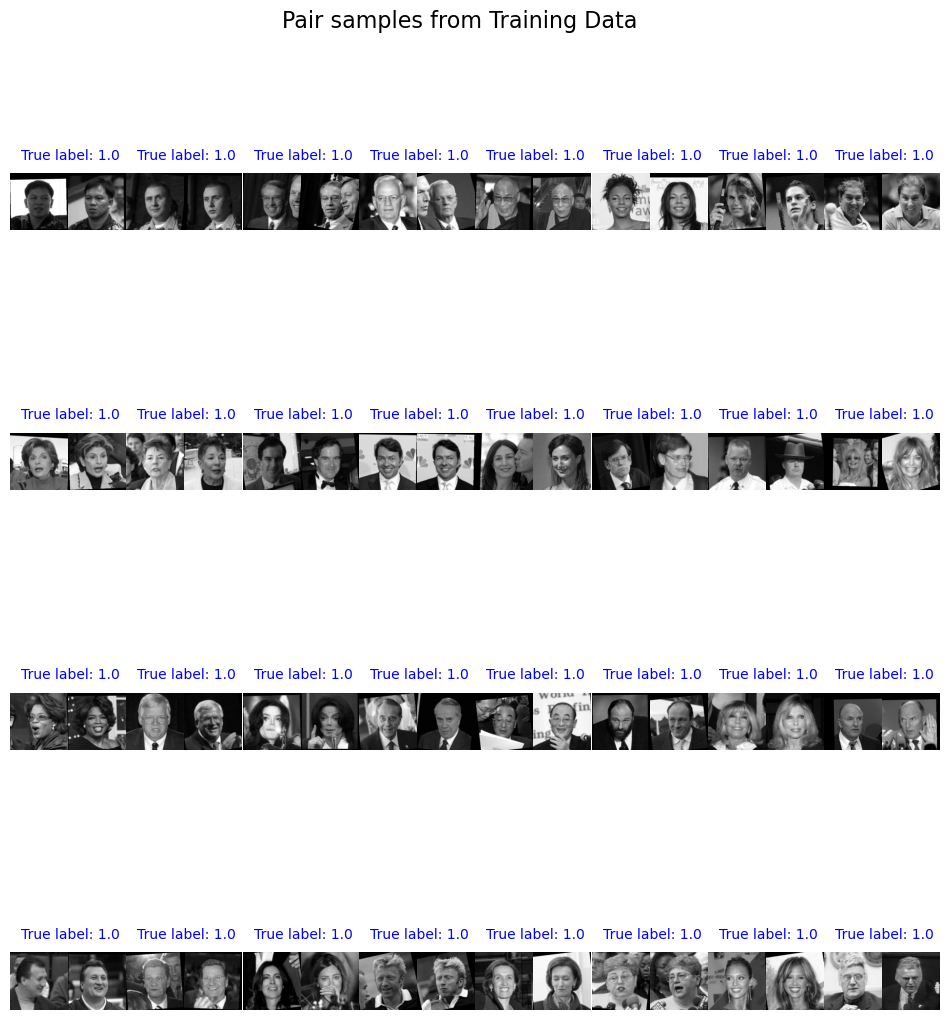

In [16]:
# Define the number of pairs to visualize and the layout
def visualize_pairs(X1,X2,y,num_pairs,pairs_per_row, title="Pair samples from Training Data",labels_title="True label",padding=10):
    if pairs_per_row == 0:
        return 
    rows = num_pairs // pairs_per_row

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(rows, pairs_per_row * 2, figsize=(12, 3 * rows))
    fig.subplots_adjust(wspace=0.01, hspace=0.8)  # Minimal space between images in a pair; more between rows

    # Plot each pair with its label
    for i in range(num_pairs):
        row = i // pairs_per_row
        col = (i % pairs_per_row) * 2  # Each pair occupies two columns

        # Display the first image of the pair (X1_train[i])
        axes[row, col].imshow(X1[i], cmap='gray')  # Adjust cmap as needed
        axes[row, col].axis('off')

        # Display the second image of the pair (X2_train[i])
        axes[row, col + 1].imshow(X2[i], cmap='gray')  # Adjust cmap as needed
        axes[row, col + 1].axis('off')

        # Add the label above the pair, centered
        label = f"{labels_title}: {y[i]}"
        axes[row, col].set_title(label, fontsize=10, color="blue", pad=padding, loc='center', x=1.05)
        axes[row, col + 1].set_title("")  # Empty title for the second image in each pair

    plt.suptitle(title, fontsize=16)
    plt.show()

visualize_pairs(X1_train, X2_train, labels_train,32,8)


# Build CNN Part

In [40]:
cnn_part = Sequential()
cnn_part.add(Conv2D(filters=64, kernel_size=(10,10), input_shape=IMG_SHAPE))
cnn_part.add(BatchNormalization())  
cnn_part.add(ReLU())  
cnn_part.add(MaxPooling2D(pool_size=(2, 2)))

cnn_part.add(Conv2D(128, (7, 7), strides=1))
cnn_part.add(BatchNormalization())  
cnn_part.add(ReLU())  
cnn_part.add(MaxPooling2D(pool_size=(2, 2)))

cnn_part.add(Conv2D(256, (4, 4), strides=1))
cnn_part.add(BatchNormalization())  
cnn_part.add(ReLU())  
cnn_part.add(MaxPooling2D(pool_size=(2, 2)))

cnn_part.add(Conv2D(256, (4, 4), strides=1))
cnn_part.add(BatchNormalization())  
cnn_part.add(ReLU())  
cnn_part.add(MaxPooling2D(pool_size=(2, 2)))


cnn_part.add(Conv2D(512, (4, 4), strides=1))
cnn_part.add(BatchNormalization())  
cnn_part.add(ReLU())  
cnn_part.add(MaxPooling2D(pool_size=(2, 2)))

cnn_part.add(Flatten())
cnn_part.add(BatchNormalization())  # Batch normalization before the dense layer's activation

cnn_part.add(Dense(1024, activation="sigmoid"))


In [41]:
cnn_part.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 241, 241, 64)      6464      
                                                                 
 batch_normalization_6 (Batc  (None, 241, 241, 64)     256       
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 241, 241, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 120, 120, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 114, 114, 128)     401536    
                                                                 
 batch_normalization_7 (Batc  (None, 114, 114, 128)   

# Build SNN

In [42]:
input1, input2 = Input(shape=IMG_SHAPE, name="Image1"), Input(shape=IMG_SHAPE, name="Image2")
# Share the single output layer for both inputs
embedding1, embedding2 = cnn_part(input1), cnn_part(input2)

In [43]:
from tensorflow.keras import backend as K

# Creating the final layer of the SNN
def euclidean_distance(vectors):
    # vectors is a list containing two tensors
    x, y = vectors
    # Compute the Euclidean distance between x and y
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def contrastive_loss(y_true, y_pred):
    """
    y_true: Binary labels (1 for similar pairs, 0 for dissimilar pairs)
    y_pred: Euclidean distances between the output embeddings
    """
    margin = 1.0  # This can be tuned
    positive_loss = y_true * K.square(y_pred)  # Loss for similar pairs
    negative_loss = (1 - y_true) * K.square(K.maximum(margin - y_pred, 0))  # Loss for dissimilar pairs
    return K.mean(positive_loss + negative_loss)  # Mean loss for the batch

In [44]:
merged = Lambda(lambda tensors: abs(tensors[0] - tensors[1]))([embedding1, embedding2])
final_output = Dense(1, activation='sigmoid')(merged)
#distance_layer = Lambda(euclidean_distance, output_shape=(1,))([embedding1, embedding2])
#final_output = Dense(1, activation='sigmoid')(distance_layer)

In [45]:
snn = Model((input1, input2), final_output)

In [46]:
from tensorflow.keras.optimizers import Adam

snn.compile(optimizer=Adam(),
              loss='binary_crossentropy',  # Loss function for classification
              metrics=['accuracy']
              )

In [47]:
snn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image1 (InputLayer)            [(None, 250, 250, 1  0           []                               
                                )]                                                                
                                                                                                  
 Image2 (InputLayer)            [(None, 250, 250, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 1024)         12506304    ['Image1[0][0]',                 
                                                                  'Image2[0][0]']           

# Train SNN

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)
snn.fit(x=[X1_train, X2_train], 
        y = labels_train, 
        batch_size = 64, 
        epochs=100,
        validation_data=([X1_test, X2_test], labels_test),
        callbacks=[es],
        shuffle=True)

Epoch 1/100
141/141 [==============================] - 4648s 33s/step - loss: 0.6723 - accuracy: 0.6206 - val_loss: 0.6478 - val_accuracy: 0.6260
Epoch 2/100
141/141 [==============================] - 4769s 34s/step - loss: 0.5537 - accuracy: 0.7219 - val_loss: 0.6439 - val_accuracy: 0.6300
Epoch 3/100
141/141 [==============================] - 4705s 33s/step - loss: 0.4792 - accuracy: 0.7746 - val_loss: 0.6367 - val_accuracy: 0.6650
Epoch 4/100
141/141 [==============================] - 4750s 34s/step - loss: 0.3929 - accuracy: 0.8376 - val_loss: 0.5936 - val_accuracy: 0.6970
Epoch 5/100
141/141 [==============================] - 4763s 34s/step - loss: 0.3148 - accuracy: 0.8819 - val_loss: 0.6329 - val_accuracy: 0.6940
Epoch 6/100
141/141 [==============================] - 4776s 34s/step - loss: 0.2283 - accuracy: 0.9269 - val_loss: 0.6480 - val_accuracy: 0.6730
Epoch 7/100
141/141 [==============================] - 4789s 34s/step - loss: 0.1619 - accuracy: 0.9510 - val_loss: 0.6208 -

# Test pair labelling accuracy

In [49]:
y_predict = snn.predict([X1_test,X2_test])
from sklearn.metrics import accuracy_score
Y_predict_decisions = []
for i in range(len(y_predict)):
    if y_predict[i] > 0.5:
        Y_predict_decisions.append(1)
    else:
        Y_predict_decisions.append(0)

# Calculate accuracy
accuracy = accuracy_score(labels_test, Y_predict_decisions)
print("Accuracy:", accuracy)

32/32 [==============================] - 135s 4s/step
Accuracy: 0.718


# Visualize predictions

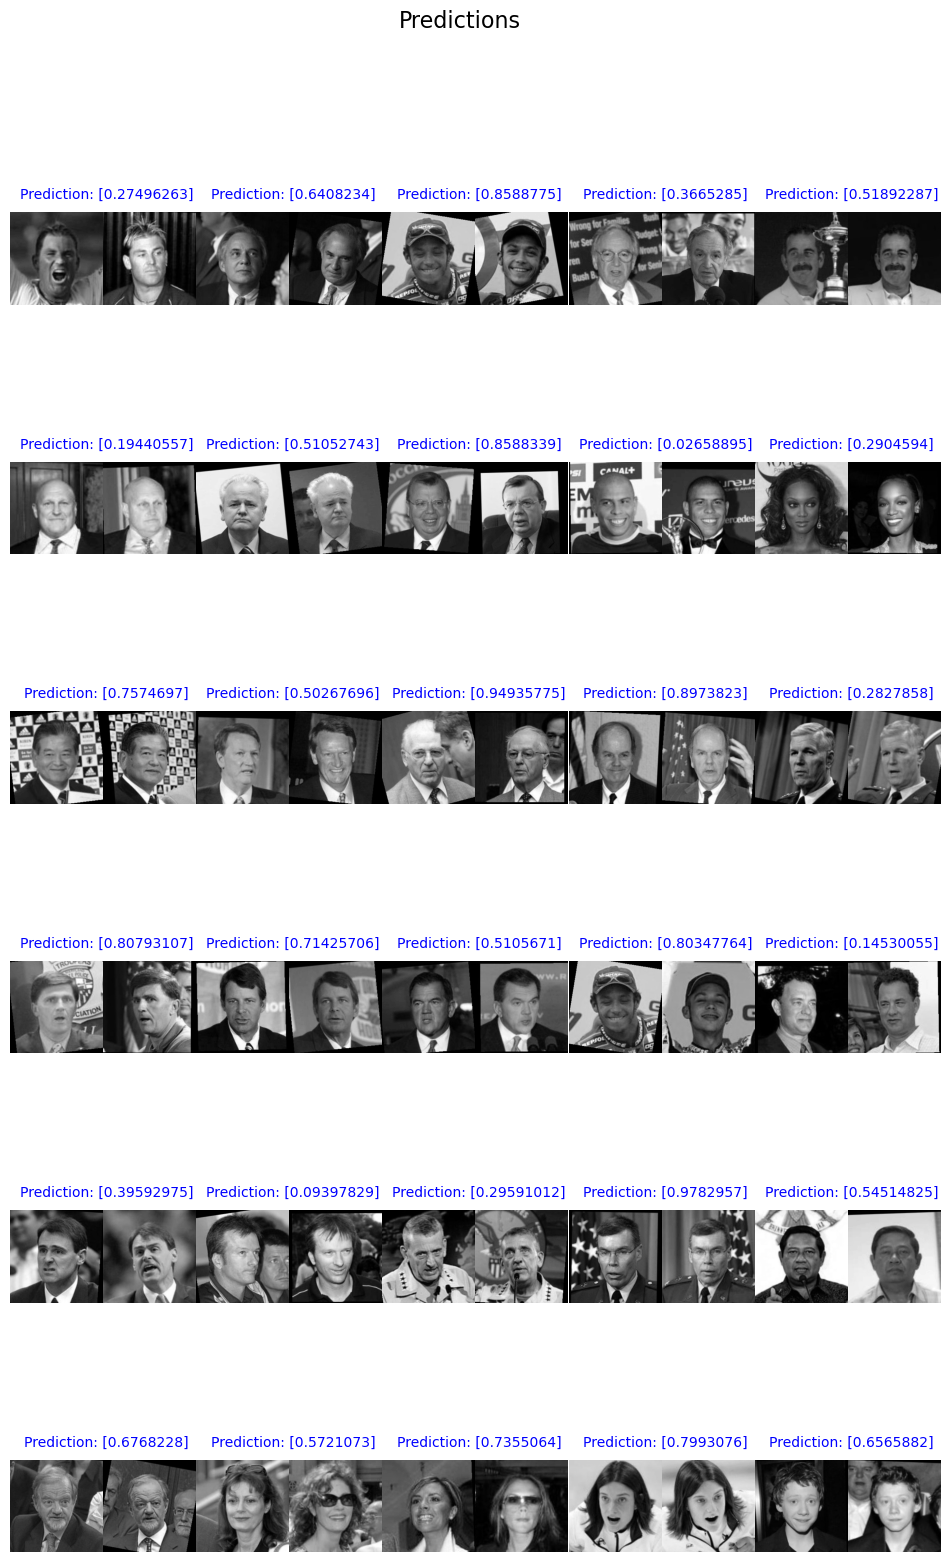

In [50]:
visualize_pairs(X1_test,X2_test,y_predict,30,5,"Predictions", "Prediction")

1/1 [==============================] - 0s 221ms/step


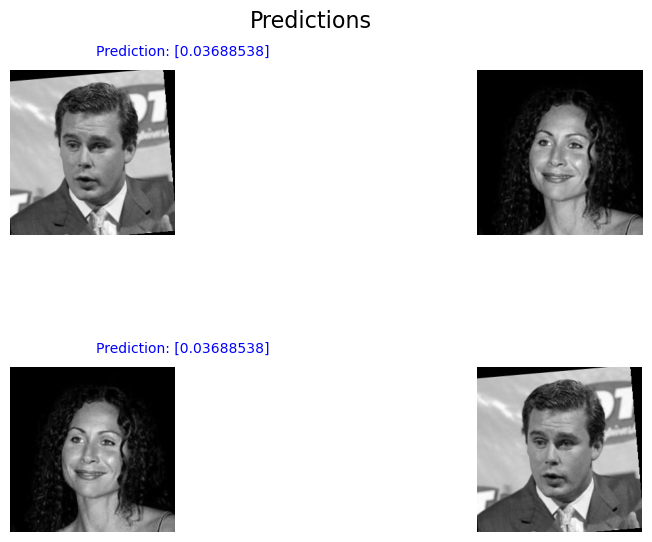

In [51]:
# Testing symmetry  
def get_random_pair(X):
    pair_indices = np.random.choice(len(X), size=2, replace=False)
    return X[pair_indices[0]], X[pair_indices[1]]

def similarity_test(person1, person2):
    X1 = np.array([person1, person2])
    X2 = np.array([person2, person1])
    predictions = snn.predict([X1,X2])
    visualize_pairs(X1,X2,predictions, 2, 1, "Predictions", "Prediction")
    return predictions
    #fig, axes = plt.subplots(1, 4, figsize=(12, 3 * rows))
    #fig.subplots_adjust(wspace=0.01, hspace=0.8) 

person1, person2 = get_random_pair(X)
similarity_predictions = similarity_test(person1, person2)




In [2]:
snn.save("siamese_network.h5")

NameError: name 'snn' is not defined

# One-shot classification testing

In [10]:
snn_model = load_model("siamese_network.h5")

In [30]:
y_predict = snn_model.predict([X1_train,X2_train])
from sklearn.metrics import accuracy_score
Y_predict_decisions = []
for i in range(len(y_predict)):
    if y_predict[i] > 0.5:
        Y_predict_decisions.append(1)
    else:
        Y_predict_decisions.append(0)

# Calculate accuracy
accuracy = accuracy_score(labels_test, Y_predict_decisions)
print("Accuracy:", accuracy)

 15/282 [>.............................] - ETA: 20:27

KeyboardInterrupt: 

In [14]:
def classification_test(snn, X, y):
    # Initialize input arrays
    X1, X2 = [], []
    # Get all images of testing dataset individuals
    unique_labels_classification_test = np.random.choice(unique_labels_test, 10)
    indices_test = np.where(np.isin(y, unique_labels_classification_test))[0]
    # Create an array containing a random image for each person to represent each person from the testing dataset (classes_images)
    index_input = np.random.choice(indices_test)
    #print(f"index_input = {index_input}")
    input_identity = y[index_input]
    input = X[index_input]

    # Create an array containing the identities of those people in the order their images are stored in classes_images, which is called classes_identities
    for unique_label in unique_labels_classification_test:
        indices_person = np.where(y == unique_label)[0]
        index_test_image = np.random.choice(indices_person)
        test_image = X[index_test_image]
        X2.append(test_image)
        X1.append(input)

    X1, X2 = np.array(X1), np.array(X2)

    # Choose one random (classification_input) image of a random person from the testing dataset for the one-shot facial recognition test, 
    # different than the images in classes_images. 

    # Create an array of pairs of images, where the first pair is classification_input and the second is an image from classes_images. Span classes_images.

    # Use the model to make predictions on the similarity of the pairs
    predictions = snn.predict([X1,X2])
    max_index = np.argmax(predictions)
    result_classification = unique_labels_test[max_index]
    is_accurate = input_identity == result_classification
    # The pair with the highest score should correspond to the identity of the person compared to classification_input
    print(f"The identity of the individual is {input_identity}\nThe predicted identity is {result_classification}")
    print(f"The maximum score is {predictions[max_index]}")
    return is_accurate, index_input, predictions, X1, X2


def one_shot_trials(snn, num_trials):
    count = 0
    for i in range(num_trials):
        if classification_test(snn, X, y)[0]:
            count += 1
    print(count/num_trials)

#classification_test(snn_model, X, y)
#one_shot_trials(snn_model, 30)

1/1 [==============================] - 1s 1s/step
The identity of the individual is Sepp_Blatter
The predicted identity is Penelope_Ann_Miller
The maximum score is [0.57170236]
10


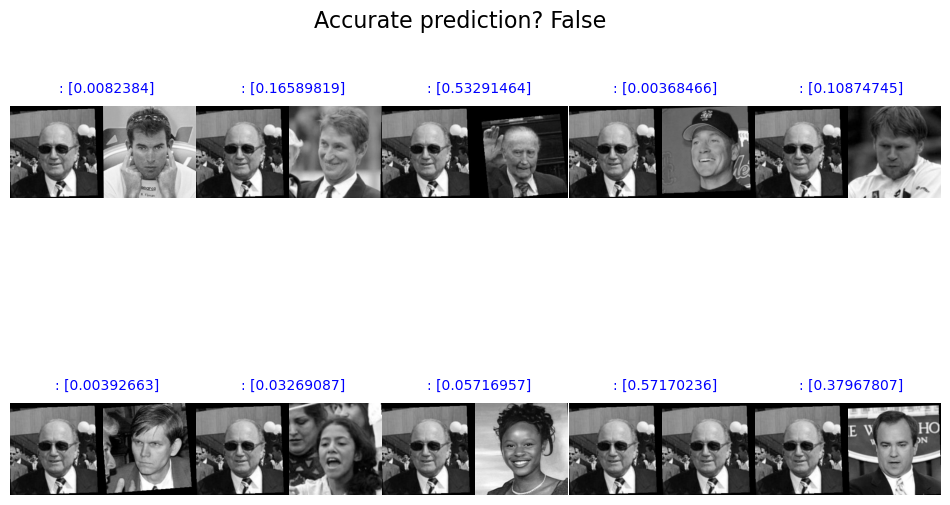

In [20]:
# Visualize a one-shot trial
is_accurate, index_input, predictions, X1, X2 = classification_test(snn_model, X, y)
print(len(predictions))
visualize_pairs(X1, X2, predictions, 10, 5, f'Accurate prediction? {is_accurate}','' )

# Next 
- Data Augmentation 
- LFW 
- Test with system 
- Generalize a visualization function